# PCA - 150m

In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FactorAnalysis

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Choose night time temperatures in July

In [3]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']

In [4]:
# choose all times between 11pm and 6am in July
temp = temp[(temp['datetime_UTC'].dt.hour>=23) | (temp['datetime_UTC'].dt.hour<6)]
temp = temp[(temp['datetime_UTC'].dt.month==7)]
temp_result = temp.groupby('station_id').mean(numeric_only=True)

In [5]:
print(temp_result)

                value
station_id           
FRASHA      17.384516
FRBETZ      18.499631
FRBRUH      18.681705
FRDIET      16.922488
FRDREI      18.395069
FREBNE      15.556083
FREICH      16.675346
FRFRIE      18.341014
FRGART      18.357788
FRGLBA      16.420968
FRGUNT      16.746728
FRHAID      18.344839
FRHBHF      19.055853
FRHERD      19.007650
FRHOCH      16.778479
FRHOLZ      17.871567
FRIHOC      17.191336
FRINST      19.600138
FRKART      19.692673
FRLAND      17.699447
FRLORE      17.066313
FRMERZ      16.635161
FRMESS      18.795806
FROPFS      16.558940
FROWIE      18.364977
FRPDAS      18.493917
FRRIES      18.808387
FRSEEP      18.413134
FRSTGA      18.632488
FRSTGE      18.516221
FRSTUH      18.801060
FRTIEN      16.376590
FRUNIK      19.291567
FRUWIE      18.135991
FRVAUB      17.823272
FRWAHS      15.966452
FRWEIN      18.648525
FRWILD      17.125023
FRWITT      18.801705
FRWSEE      17.621198
FRZAHR      18.148940


### Import Urban Form Parameters

In [6]:
# import and drop index
params = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_150.parquet')

In [7]:
params = params[params['station_id']!='FRTECH']
params = params.merge(temp_result, left_on='station_id', right_on='station_id',how='inner')

In [8]:
params.index = params['station_id']

In [9]:
items = [
    'BuAre_count', 'BuAre_sum', 'BuAre_mean', 'BuAre_std', 
    'BuHt_mean', 'BuHt_std', 
    'BuPer_mean', 'BuPer_std', 
    'BuLAL_mean', 'BuLAL_std', 
    'BuCCD_mean_mean', 'BuCCD_mean_std', 
    'BuCor_mean', 'BuCor_std', 
    'CyAre_sum', 'CyAre_mean', 'CyAre_std', 
    'CyInd_mean', 'CyInd_std', 
    'BuCWA_mean', 'BuCWA_std', 
    'BuCon_mean', 'BuCon_std', 
    'BuElo_mean', 'BuElo_std', 
    'BuERI_mean', 'BuERI_std', 
    'BuFR_mean', 'BuFR_std', 
    'BuFF_mean', 'BuFF_std', 
    'BuFD_mean', 'BuFD_std', 
    'BuRec_mean', 'BuRec_std', 
    'BuShI_mean', 'BuShI_std', 
    'BuSqC_mean', 'BuSqC_std', 
    'BuSqu_mean', 'BuSqu_std', 
    'BuAdj', 
    'BuIBD', 
    'BuSWR_mean', 'BuSWR_std', 
    'BuOri_mean', 'BuOri_std', 
    'BuAli_mean', 'BuAli_std', 
    'StrAli_mean', 'StrAli_std', 
    'StrW_mean', 'StrW_std', 
    'StrWD_mean', 'StrWD_std', 
    'StrOpe_mean', 'StrOpe_std', 
    'StrHW_mean', 'StrHW_std', 
    'StrLen_mean', 'StrLen_std', 
    'StrCNS_mean', 'StrCNS_std', 
    'BpM_mean', 'BpM_std', 
    'StrLin_mean', 'StrLin_std', 
    'StrClo400_mean', 'StrClo400_std', 
    'StrBet400_mean', 'StrBet400_std', 
    'StrSCl_mean', 'StrSCl_std', 
    'StrCyc400_mean', 'StrCyc400_std', 
    'StrENR400_mean', 'StrENR400_std', 
    'StrGam400_mean', 'StrGam400_std', 
    'StrDeg_mean', 'StrDeg_std', 
    'StrMes400_mean', 'StrMes400_std',
    'StrClo1200_mean', 'StrClo1200_std', 
    'StrBet1200_mean', 'StrBet1200_std',  
    'StrCyc1200_mean', 'StrCyc1200_std', 
    'StrENR1200_mean', 'StrENR1200_std', 
    'StrGam1200_mean', 'StrGam1200_std', 
    'StrMes1200_mean', 'StrMes1200_std'
]


In [10]:
params = params[items]
params = params.merge(temp_result, left_on='station_id', right_on='station_id',how='inner')

In [11]:
# standardize data
scaler = StandardScaler()
params_scaled = scaler.fit_transform(params)
params_scaled = pd.DataFrame(params_scaled, columns=params.columns, index=params.index)
params_scaled = params_scaled.dropna(thresh=params_scaled.shape[0] - 7, axis=1)

# Correlate Parameters

In [12]:
corr = params_scaled.corr()

In [13]:
long_df = corr.reset_index().melt(id_vars='index', var_name='Variable', value_name='Correlation')

# Create the heatmap using Altair
heatmap = alt.Chart(long_df).mark_rect().encode(
    x=alt.X('index:N', title='Variables', sort=None),  # Column names
    y=alt.Y('Variable:N', title='Variables', sort=None),  # Row names
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis'), title='Correlation'),
    tooltip=['index', 'Variable', 'Correlation']  # Tooltips for interactivity
).properties(
    width=1000,
    height=1000,
    title='Correlation Heatmap'
).interactive()

# Display the heatmap
heatmap.show()

alt.Chart(...)

In [28]:
# sklearn factor analysis of params_scaled

X_scaled = params_scaled.drop('value', axis=1)
X_scaled = X_scaled.dropna()

# Step 2: Determine the number of factors (e.g., set manually or use eigenvalues)
n_factors = 7  # Example: Choose 5 factors

# Step 3: Perform Factor Analysis
fa = FactorAnalysis(n_components=n_factors, random_state=0)
fa.fit(X_scaled)

# Step 4: Analyze Results
factor_loadings = pd.DataFrame(fa.components_.T, index=X_scaled.columns, columns=[f"Factor {i+1}" for i in range(n_factors)])

# Display the factor loadings
print(factor_loadings)


                 Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  \
BuAre_count     -0.618250  0.254131  0.267521 -0.039110 -0.103790  0.049162   
BuAre_sum        0.438111  0.308448  0.064341 -0.038375 -0.209698  0.198824   
BuAre_mean       0.569002 -0.046711 -0.028161 -0.002392  0.015531 -0.063059   
BuAre_std        0.662933  0.088097 -0.012375  0.034648 -0.013471 -0.073707   
BuHt_mean        0.542750 -0.058992  0.170397  0.039081 -0.377172  0.242216   
BuHt_std         0.188140  0.054290 -0.098327 -0.201357 -0.199650  0.197644   
BuPer_mean       0.748375 -0.115069 -0.010022 -0.001865 -0.008800 -0.005886   
BuPer_std        0.728370 -0.010529 -0.086519 -0.005122 -0.002872 -0.053152   
BuLAL_mean       0.697476 -0.115040 -0.008638  0.016459  0.026511  0.017910   
BuLAL_std        0.672380 -0.051926 -0.100395  0.034305  0.026410 -0.017451   
BuCCD_mean_mean  0.620952 -0.118408 -0.056697  0.011271  0.100371  0.043728   
BuCCD_mean_std   0.529256 -0.022434 -0.110541  0.041

In [29]:
# find top 5 factor loadings
factor_loadings_abs = factor_loadings.abs()
max_loadings = factor_loadings_abs.idxmax(axis=0)
max_loadings = max_loadings.reset_index()
max_loadings.columns = ['Factor', 'Variable']
print(max_loadings)


     Factor         Variable
0  Factor 1       BuPer_mean
1  Factor 2       CyAre_mean
2  Factor 3        BuFD_mean
3  Factor 4   StrENR1200_std
4  Factor 5  StrGam1200_mean
5  Factor 6  StrBet1200_mean
6  Factor 7      StrLin_mean


In [30]:
# for each factor, print the top 5 highest loadings

for i in range(n_factors):
    print(factor_loadings_abs.nlargest(5, f'Factor {i+1}'))



            Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  \
BuPer_mean  0.748375  0.115069  0.010022  0.001865  0.008800  0.005886   
BuPer_std   0.728370  0.010529  0.086519  0.005122  0.002872  0.053152   
BuCWA_std   0.725471  0.114850  0.057071  0.054648  0.010181  0.006758   
BuFR_mean   0.703505  0.164579  0.147481  0.033929  0.020253  0.006816   
BuLAL_mean  0.697476  0.115040  0.008638  0.016459  0.026511  0.017910   

            Factor 7  
BuPer_mean  0.000285  
BuPer_std   0.273917  
BuCWA_std   0.394527  
BuFR_mean   0.118751  
BuLAL_mean  0.005636  
            Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  \
CyAre_mean  0.358502  1.032582  0.033576  0.078984  0.038976  0.030482   
CyAre_std   0.288028  1.032420  0.063193  0.092264  0.077491  0.045729   
CyAre_sum   0.237509  1.024986  0.090039  0.090245  0.100083  0.037890   
CyInd_std   0.433409  1.020737  0.006325  0.037469  0.002666  0.002433   
CyInd_mean  0.511142  0.973666  0.040366  0.026

# PCA

In [13]:
# select all but values column
X_scaled = params_scaled.drop('value', axis=1)

In [15]:
# Select the relevant variables and standardize them
X_scaled = X_scaled.dropna()

In [56]:
X_scaled

,BuAre_count,BuAre_sum,BuAre_mean,BuAre_std,BuHt_mean,BuHt_std,BuPer_mean,BuPer_std,BuLAL_mean,BuLAL_std,BuCCD_mean_mean,BuCCD_mean_std,BuCor_mean,BuCor_std,CyAre_sum,CyAre_mean,CyAre_std,CyInd_mean,CyInd_std,BuCWA_mean,BuCWA_std,BuCon_mean,BuCon_std,BuElo_mean,BuElo_std,BuERI_mean,BuERI_std,BuFR_mean,BuFR_std,BuFF_mean,BuFF_std,BuFD_mean,BuFD_std,BuRec_mean,BuRec_std,BuShI_mean,BuShI_std,BuSqC_mean,BuSqC_std,BuSqu_mean,BuSqu_std,BuAdj,BuIBD,BuSWR_mean,BuSWR_std,BuOri_mean,BuOri_std,BuAli_mean,BuAli_std,StrAli_mean,StrAli_std,StrW_mean,StrW_std,StrWD_mean,StrWD_std,StrOpe_mean,StrOpe_std,StrHW_mean,StrHW_std,StrLen_mean,StrLen_std,StrCNS_mean,StrCNS_std,BpM_mean,BpM_std,StrLin_mean,StrLin_std,StrClo400_mean,StrClo400_std,StrBet400_mean,StrBet400_std,StrSCl_mean,StrSCl_std,StrCyc400_mean,StrCyc400_std,StrENR400_mean,StrENR400_std,StrGam400_mean,StrGam400_std,StrDeg_mean,StrDeg_std,StrMes400_mean,StrMes400_std,StrClo1200_mean,StrClo1200_std,StrBet1200_mean,StrBet1200_std,StrCyc1200_mean,StrCyc1200_std,StrENR1200_mean,StrENR1200_std,StrGam1200_mean,StrGam1200_std,StrMes1200_mean,StrMes1200_std
station_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FRASHA,-0.151218,-0.698961,-0.573337,-0.412014,-0.335127,0.174435,-0.807737,-0.442441,-0.768236,-0.314315,-0.709730,-0.209364,-0.799303,-0.796152,-0.297861,-0.314484,-0.306805,-0.327281,-0.332071,-0.847331,-0.364854,0.849178,-0.826452,1.388224,0.263313,0.942504,-1.140010,-0.660160,-0.344048,-1.243045,-1.110518,-1.034584,-1.031668,0.855829,-0.852335,1.306849,-0.405985,1.347113,-1.191172,-0.816334,-1.277782,1.285163,-0.072210,-1.038736,-0.693627,-0.645594,1.169557,0.594826,0.161427,0.363072,0.414654,0.736959,1.723747,1.923906,-0.181681,1.008565,1.319391,-0.429396,-0.390181,-0.726318,0.818695,-0.151327,-0.062313,1.755348,3.067305,-1.369017,1.162145,0.142243,3.074376,-0.698311,-0.728456,-0.739476,0.286623,-0.690700,-0.113744,-0.857214,2.083833,2.237409,3.447455,-1.326250,1.399950,1.740128,4.430917,-0.676425,1.417173,-0.876634,-0.787959,-0.933663,0.453194,-1.657161,4.105727,1.049743,2.190768,-0.821892,4.165193
FRBETZ,0.655708,-0.178180,-0.595290,-0.338512,-0.460708,0.974901,-0.841954,-0.171390,-0.842890,-0.382823,-0.812492,-0.369753,-0.861446,-0.468958,3.867527,3.444458,3.770952,2.297970,2.789723,-0.747267,-0.367991,0.479062,-0.169826,-0.501215,-1.238896,0.428536,0.104426,-0.914211,-0.267914,-0.725140,-0.271291,-0.017044,-0.891214,0.637965,-0.319847,0.210829,-1.214317,0.433672,-0.719509,-0.415844,-0.316567,-1.361083,-0.568984,1.772066,1.150913,1.612930,-0.364917,-0.452491,1.032284,-0.352109,-0.177286,-0.029320,-1.301654,1.454036,-2.291161,-0.305302,-0.502791,-0.196827,-0.114895,1.218235,-1.228917,-0.812528,-0.699631,2.964367,3.590703,-2.421364,-0.599784,-1.063019,-0.553167,-0.677641,-0.655396,-1.241043,-1.307848,-0.920004,-1.027266,-1.900885,0.460937,0.505226,2.702128,-2.441676,1.164193,-1.784238,-0.668867,-0.901738,0.776537,-0.837676,-0.703986,-0.985414,-0.316479,-1.587750,0.000030,-1.896390,1.152995,-1.796849,0.269095
FRDREI,-0.745796,-0.359651,0.074468,-0.150227,1.466217,-0.036835,0.402900,-0.065318,0.443798,0.114993,0.461293,0.013668,-0.479093,-0.653179,-0.297861,-0.314484,-0.306805,-0.327281,-0.332071,0.261213,0.343547,0.238676,0.343934,0.079212,-0.016595,0.332819,-0.082769,0.598764,-0.418188,0.085969,-0.052273,-0.523911,0.016458,0.429131,0.357118,0.192530,0.917717,0.308183,0.499739,-0.576781,-0.265344,-0.719938,1.675455,0.254362,-0.023959,0.935975,-0.800512,-0.879253,-1.216033,-0.221168,0.959318,0.001000,0.919327,-0.644095,1.379722,0.083916,1.029113,0.521778,0.340982,-0.408524,-0.095028,-0.237319,-0.312678,-0.865861,-0.313105,-0.555920,0.887636,-0.388482,-0.576030,-0.311801,-0.251541,0.660732,-1.307848,-0.474134,-0.674717,-0.107029,-0.807098,-0.603861,-0.483559,-0.039219,-1.589317,-0.327594,-0.433227,-0.341121,-0.549757,0.639549,0.636933,-0.689572,-0.403257,-0.932362,-0.275234,-1.294405,-0.178260,-1.144177,-0.278095
FRGART,1.972272,-0.

In [16]:
# Perform PCA
pca = PCA()
pca.fit(X_scaled)

PCA()

In [20]:
# Get the loadings
loadings = pd.DataFrame(pca.components_, columns=[f'PC{i+1}' for i in range(pca.components_.shape[1])], index=X_scaled.index)
print(loadings)

                 PC1       PC2       PC3       PC4       PC5       PC6  \
station_id                                                               
FRASHA     -0.053477  0.125182  0.079407  0.107145  0.153636  0.059854   
FRBETZ      0.023572  0.044643 -0.011941  0.023471 -0.042211  0.005060   
FRDREI     -0.236130 -0.037092  0.143195  0.161719  0.021149  0.008685   
FRGART     -0.111321 -0.037628 -0.001164 -0.016410  0.038956  0.041992   
FRGUNT      0.027006 -0.082151 -0.027978 -0.031944 -0.018903 -0.167279   
FRHAID      0.053418 -0.100408 -0.068489 -0.075208 -0.105842  0.000494   
FRHBHF     -0.030857  0.050209  0.061582  0.027615 -0.121001 -0.243302   
FRHERD     -0.041029  0.024956 -0.020236 -0.055223  0.113070  0.011197   
FRHOLZ      0.003038 -0.106898 -0.041741 -0.036535  0.084017 -0.074567   
FRIHOC     -0.096465 -0.037957  0.028576  0.018289 -0.057610  0.066442   
FRINST      0.129826  0.066939 -0.029646  0.020128  0.003582 -0.174447   
FRKART     -0.053032 -0.071002 -0.0352

In [21]:
loadings['PC1'].sort_values(ascending=False)

station_id
FRLORE    0.131698
FRINST    0.129826
FRSTGA    0.104660
FRSTUH    0.099379
FRWSEE    0.096170
FRUWIE    0.080348
FRLAND    0.059947
FRHAID    0.053418
FRGUNT    0.027006
FRBETZ    0.023572
FRZAHR    0.023095
FRUNIK    0.017533
FRSTGE    0.017059
FRHOLZ    0.003038
FRHBHF   -0.030857
FRHERD   -0.041029
FRRIES   -0.049087
FRKART   -0.053032
FRASHA   -0.053477
FRVAUB   -0.069213
FRWEIN   -0.092489
FRIHOC   -0.096465
FROWIE   -0.098644
FRGART   -0.111321
FRPDAS   -0.182781
FRDREI   -0.236130
Name: PC1, dtype: float64

In [22]:
loadings['PC2'].sort_values(ascending=False)

station_id
FRLORE    0.170045
FRUWIE    0.159380
FRSTUH    0.155926
FRVAUB    0.151203
FRASHA    0.125182
FRLAND    0.108102
FRINST    0.066939
FRSTGE    0.063366
FRHBHF    0.050209
FRBETZ    0.044643
FRZAHR    0.025252
FRHERD    0.024956
FRPDAS   -0.000917
FRWEIN   -0.021014
FRWSEE   -0.021383
FRDREI   -0.037092
FRGART   -0.037628
FRIHOC   -0.037957
FRKART   -0.071002
FRSTGA   -0.076080
FRRIES   -0.080726
FRGUNT   -0.082151
FRHAID   -0.100408
FRHOLZ   -0.106898
FROWIE   -0.110032
FRUNIK   -0.112070
Name: PC2, dtype: float64

In [54]:
loadings['PC2'].sort_values(ascending=False)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [24]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

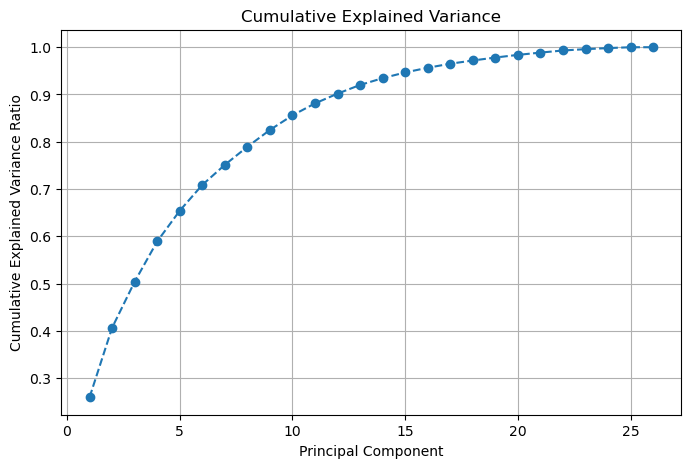

In [25]:
# Create a cumulative variance plot
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

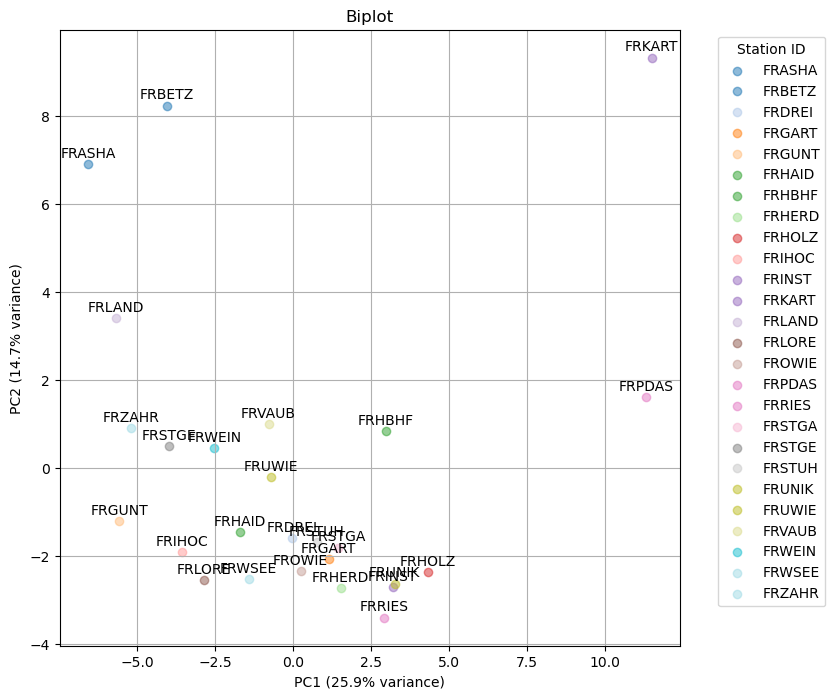

In [26]:
# Assuming params_mean has a 'station_id' column
station_ids = params_scaled.dropna().index
unique_station_ids = station_ids.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_station_ids)))
color_map = dict(zip(unique_station_ids, colors))

# Plotting the loadings (biplot)
loadings = pca.components_.T

plt.figure(figsize=(8, 8))

# Uncomment if you want to plot the arrows and text for loadings
# for i, var in enumerate(params_mean.columns):
#     plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
#     plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, var, color='g', ha='center', va='center')

# Scatter plot with colors and labels for station_id
for station_id in unique_station_ids:
    idx = station_ids == station_id
    transformed_data = pca.transform(X_scaled)[idx]
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], 
                alpha=0.5, color=color_map[station_id], label=station_id)
    for i in range(len(transformed_data)):
        plt.annotate(station_id, (transformed_data[i, 0], transformed_data[i, 1]), 
                     textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.1%} variance)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.1%} variance)")
plt.title('Biplot')
plt.grid(True)
plt.legend(title='Station ID',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [60]:
transformed_data

array([[-6.57350290e+00,  6.90036269e+00,  3.40306089e-01,
         5.46325934e+00,  3.44317749e+00, -4.47024398e+00,
        -1.42581314e+00, -2.36136765e+00,  8.28828571e-01,
         1.98932259e+00, -6.02586231e-01,  1.08502727e+00,
         9.49451079e-01, -7.71685898e-01, -2.10183416e-01,
        -1.19929235e-01, -2.12689812e-01, -1.21705883e-01,
         3.01505238e-01,  1.60823444e-01, -8.60215356e-02,
         5.98713070e-02, -1.55837264e-01, -5.28843685e-02,
        -1.27567396e-03,  1.46852076e-16],
       [-4.03083714e+00,  8.23007620e+00,  1.31578068e+00,
        -6.39218764e+00, -2.65075965e+00,  1.39497801e+00,
        -2.62680367e+00,  2.67833751e+00,  9.89480232e-01,
         2.35255027e+00, -1.18523917e+00,  2.60015033e-01,
        -4.41763946e-01, -1.26223257e-01,  4.86672890e-01,
         1.14400155e-01, -4.04644958e-01,  6.32095956e-01,
        -3.65306009e-01, -1.14496858e-01, -1.64371198e-01,
        -1.21706440e-01,  3.05376531e-02, -1.41609011e-01,
        -9.90

NameError: name 'explained_variance_ratio' is not defined

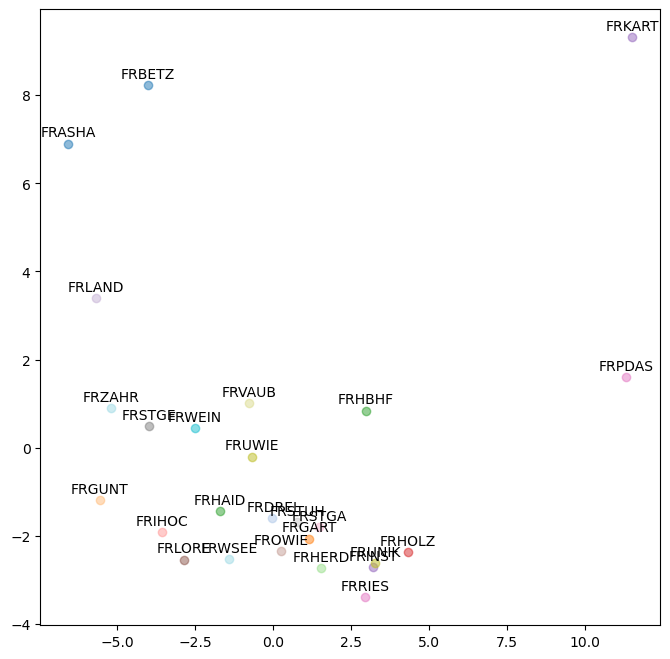

In [23]:
# Assuming params_mean has a 'station_id' column
station_ids = params_scaled.dropna().index
unique_station_ids = station_ids.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_station_ids)))
color_map = dict(zip(unique_station_ids, colors))

# Plotting the loadings (biplot)
loadings = pca.components_.T

plt.figure(figsize=(8, 8))

# Uncomment if you want to plot the arrows and text for loadings
# for i, var in enumerate(params_mean.columns):
#     plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
#     plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, var, color='g', ha='center', va='center')

# Scatter plot with colors and labels for station_id
for station_id in unique_station_ids:
    idx = station_ids == station_id
    transformed_data = pca.transform(X_scaled)[idx]
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], 
                alpha=0.5, color=color_map[station_id], label=station_id)
    for i in range(len(transformed_data)):
        plt.annotate(station_id, (transformed_data[i, 0], transformed_data[i, 1]), 
                     textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.1%} variance)")
plt.ylabel(f"PC7 ({explained_variance_ratio[1]:.1%} variance)")
plt.title('Biplot')
plt.grid(True)
plt.legend(title='Station ID',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [35]:
params_scaled

,BuAre_count,BuAre_sum,BuAre_mean,BuAre_std,BuHt_mean,BuHt_std,BuPer_mean,BuPer_std,BuLAL_mean,BuLAL_std,BuCCD_mean_mean,BuCCD_mean_std,BuCor_mean,BuCor_std,CyAre_sum,CyAre_mean,CyAre_std,CyInd_mean,CyInd_std,BuCWA_mean,BuCWA_std,BuCon_mean,BuCon_std,BuElo_mean,BuElo_std,BuERI_mean,BuERI_std,BuFR_mean,BuFR_std,BuFF_mean,BuFF_std,BuFD_mean,BuFD_std,BuRec_mean,BuRec_std,BuShI_mean,BuShI_std,BuSqC_mean,BuSqC_std,BuSqu_mean,BuSqu_std,BuAdj,BuIBD,BuSWR_mean,BuSWR_std,BuOri_mean,BuOri_std,BuAli_mean,BuAli_std,StrAli_mean,StrAli_std,StrW_mean,StrW_std,StrWD_mean,StrWD_std,StrOpe_mean,StrOpe_std,StrHW_mean,StrHW_std,StrLen_mean,StrLen_std,StrCNS_mean,StrCNS_std,BpM_mean,BpM_std,StrLin_mean,StrLin_std,StrClo400_mean,StrClo400_std,StrBet400_mean,StrBet400_std,StrSCl_mean,StrSCl_std,StrCyc400_mean,StrCyc400_std,StrENR400_mean,StrENR400_std,StrGam400_mean,StrGam400_std,StrDeg_mean,StrDeg_std,StrMes400_mean,StrMes400_std,StrClo1200_mean,StrClo1200_std,StrBet1200_mean,StrBet1200_std,StrCyc1200_mean,StrCyc1200_std,StrENR1200_mean,StrENR1200_std,StrGam1200_mean,StrGam1200_std,StrMes1200_mean,StrMes1200_std,value
station_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FRASHA,-0.151218,-0.698961,-0.573337,-0.412014,-0.335127,0.174435,-0.807737,-0.442441,-0.768236,-0.314315,-0.709730,-0.209364,-0.799303,-0.796152,-0.297861,-0.314484,-0.306805,-0.327281,-0.332071,-0.847331,-0.364854,0.849178,-0.826452,1.388224,0.263313,0.942504,-1.140010,-0.660160,-0.344048,-1.243045,-1.110518,-1.034584,-1.031668,0.855829,-0.852335,1.306849,-0.405985,1.347113,-1.191172,-0.816334,-1.277782,1.285163,-0.072210,-1.038736,-0.693627,-0.645594,1.169557,0.594826,0.161427,0.363072,0.414654,0.736959,1.723747,1.923906,-0.181681,1.008565,1.319391,-0.429396,-0.390181,-0.726318,0.818695,-0.151327,-0.062313,1.755348,3.067305,-1.369017,1.162145,0.142243,3.074376,-0.698311,-0.728456,-0.739476,0.286623,-0.690700,-0.113744,-0.857214,2.083833,2.237409,3.447455,-1.326250,1.399950,1.740128,4.430917,-0.676425,1.417173,-0.876634,-0.787959,-0.933663,0.453194,-1.657161,4.105727,1.049743,2.190768,-0.821892,4.165193,-1.004757
FRBETZ,0.655708,-0.178180,-0.595290,-0.338512,-0.460708,0.974901,-0.841954,-0.171390,-0.842890,-0.382823,-0.812492,-0.369753,-0.861446,-0.468958,3.867527,3.444458,3.770952,2.297970,2.789723,-0.747267,-0.367991,0.479062,-0.169826,-0.501215,-1.238896,0.428536,0.104426,-0.914211,-0.267914,-0.725140,-0.271291,-0.017044,-0.891214,0.637965,-0.319847,0.210829,-1.214317,0.433672,-0.719509,-0.415844,-0.316567,-1.361083,-0.568984,1.772066,1.150913,1.612930,-0.364917,-0.452491,1.032284,-0.352109,-0.177286,-0.029320,-1.301654,1.454036,-2.291161,-0.305302,-0.502791,-0.196827,-0.114895,1.218235,-1.228917,-0.812528,-0.699631,2.964367,3.590703,-2.421364,-0.599784,-1.063019,-0.553167,-0.677641,-0.655396,-1.241043,-1.307848,-0.920004,-1.027266,-1.900885,0.460937,0.505226,2.702128,-2.441676,1.164193,-1.784238,-0.668867,-0.901738,0.776537,-0.837676,-0.703986,-0.985414,-0.316479,-1.587750,0.000030,-1.896390,1.152995,-1.796849,0.269095,0.371544
FRBRUH,-1.021849,2.150590,3.853515,3.728448,-0.489649,0.290844,2.800428,2.567869,2.656478,2.522363,2.458584,2.521303,0.634112,-0.124682,-0.297861,-0.314484,-0.306805,-0.327281,-0.332071,2.225605,1.438075,0.057702,-0.014358,-0.823778,0.864438,-0.133021,0.263697,3.107478,3.880776,0.313355,0.181090,-0.022656,-0.350233,0.359781,-0.645004,-0.537753,0.390699,-0.544899,0.454109,-0.665059,-0.936034,0.644066,1.816140,-0.556592,0.297352,0.504283,-0.368359,0.630798,-0.766004,-0.476404,-0.756759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.596264
FRDIET,-1.489017,-1.628296,-0.008758,0.380878,0.207661,2.448707,-0.119408,1.502863,-0.349207,1.110792,-0.557158,0.757383,0.686410,1.065043,-0.297861,-0.314484,-0.306805,-0.327281,-0.332071,0.066560,0.892767,-1.320638,3.636732,1.958750,-2.8

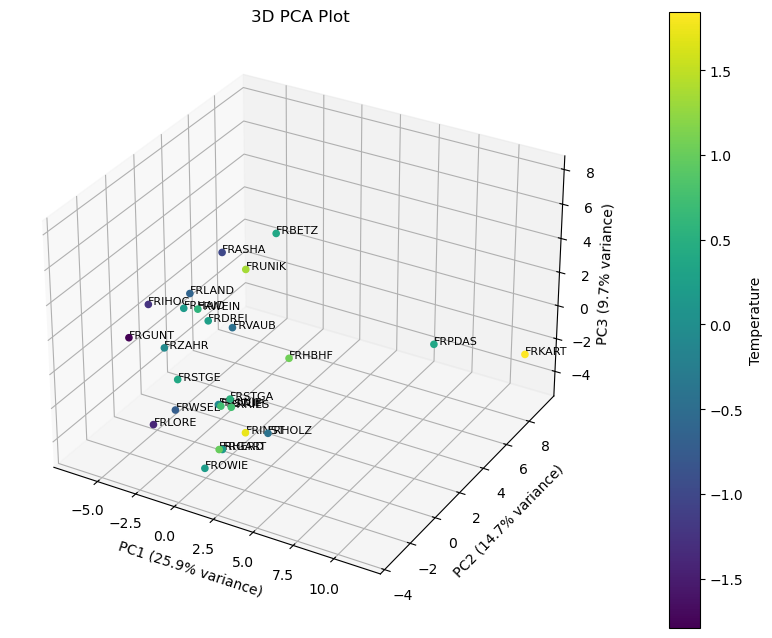

In [36]:
# Assuming params_mean has a 'station_id' column
station_ids = X_scaled.dropna().index
unique_station_ids = station_ids.unique()

# Transform the data using PCA
transformed_data = pca.transform(X_scaled)

# Assuming temp_result is a numpy array or pandas Series with the same length as transformed_data
temp_result = params_scaled.dropna()['value']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors corresponding to temp_result
sc = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], 
                alpha=1, c=temp_result, cmap='viridis')

# Add color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Temperature')

# Add text labels for station_id
for station_id in unique_station_ids:
    idx = station_ids == station_id
    for i in range(len(transformed_data[idx])):
        ax.text(transformed_data[idx][i, 0], transformed_data[idx][i, 1], transformed_data[idx][i, 2], 
                station_id, size=8, zorder=1, color='k')

ax.set_xlabel(f"PC1 ({explained_variance_ratio[0]:.1%} variance)")
ax.set_ylabel(f"PC2 ({explained_variance_ratio[1]:.1%} variance)")
ax.set_zlabel(f"PC3 ({explained_variance_ratio[2]:.1%} variance)")
ax.zaxis.labelpad=-0.5

ax.set_title('3D PCA Plot')
plt.show()

In [39]:
# Convert loadings to DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=X_scaled.columns)

In [40]:
loadings_df = loadings_df.reset_index()  # Move the index into a column
loadings_df.rename(columns={"index": "Feature"}, inplace=True)

In [41]:
pc_names = [f"PC{i}" for i in range(1, 27)]

In [44]:
# Melt the DataFrame for Altair compatibility
data_melted = loadings_df.melt(id_vars=["Feature"], var_name="Principal Component", value_name="Value")

# Create the heatmap
heatmap = alt.Chart(data_melted).mark_rect().encode(
    x=alt.X("Principal Component:O", title="Principal Components", sort=pc_names),
    y=alt.Y("Feature:O", title="Features"),
    color=alt.Color("Value:Q", scale=alt.Scale(scheme="viridis"), title="Correlation"),
    tooltip=["Feature", "Principal Component", "Value"]
).properties(
    width=800,
    height=1500,
    title="Interactive Heatmap of Features vs Principal Components"
).interactive()

heatmap.display()


alt.Chart(...)

In [45]:
# Assume `loadings` is a 2D numpy array with variables as rows and PCs as columns
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])

# the index should be the variable names
loadings_df.index = X_scaled.columns

# Focus on the first x PCs
loadings_subset = loadings_df.iloc[:, :15]

In [46]:
correlation_matrix = loadings_subset.T.corr()
# Define a threshold for high correlation (e.g., 0.8)
threshold = 0.8

# Find variable pairs with high absolute correlation
high_corr_pairs = [(var1, var2) for var1 in correlation_matrix.columns for var2 in correlation_matrix.columns 
                   if abs(correlation_matrix.loc[var1, var2]) > threshold and var1 != var2]

In [47]:
high_corr_pairs

[('BuAre_mean', 'BuAre_std'),
 ('BuAre_mean', 'BuPer_mean'),
 ('BuAre_mean', 'BuPer_std'),
 ('BuAre_mean', 'BuLAL_mean'),
 ('BuAre_mean', 'BuLAL_std'),
 ('BuAre_mean', 'BuCCD_mean_mean'),
 ('BuAre_mean', 'BuCCD_mean_std'),
 ('BuAre_mean', 'BuCWA_mean'),
 ('BuAre_mean', 'BuFR_mean'),
 ('BuAre_mean', 'BuFR_std'),
 ('BuAre_std', 'BuAre_mean'),
 ('BuAre_std', 'BuPer_mean'),
 ('BuAre_std', 'BuPer_std'),
 ('BuAre_std', 'BuLAL_mean'),
 ('BuAre_std', 'BuLAL_std'),
 ('BuAre_std', 'BuCCD_mean_std'),
 ('BuAre_std', 'BuCWA_mean'),
 ('BuAre_std', 'BuFR_std'),
 ('BuPer_mean', 'BuAre_mean'),
 ('BuPer_mean', 'BuAre_std'),
 ('BuPer_mean', 'BuPer_std'),
 ('BuPer_mean', 'BuLAL_mean'),
 ('BuPer_mean', 'BuLAL_std'),
 ('BuPer_mean', 'BuCCD_mean_mean'),
 ('BuPer_mean', 'BuCCD_mean_std'),
 ('BuPer_mean', 'BuCWA_mean'),
 ('BuPer_mean', 'BuFR_mean'),
 ('BuPer_std', 'BuAre_mean'),
 ('BuPer_std', 'BuAre_std'),
 ('BuPer_std', 'BuPer_mean'),
 ('BuPer_std', 'BuLAL_mean'),
 ('BuPer_std', 'BuLAL_std'),
 ('BuPer_std', 

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_24291/832106605.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - abs(correlation_matrix), method='ward')


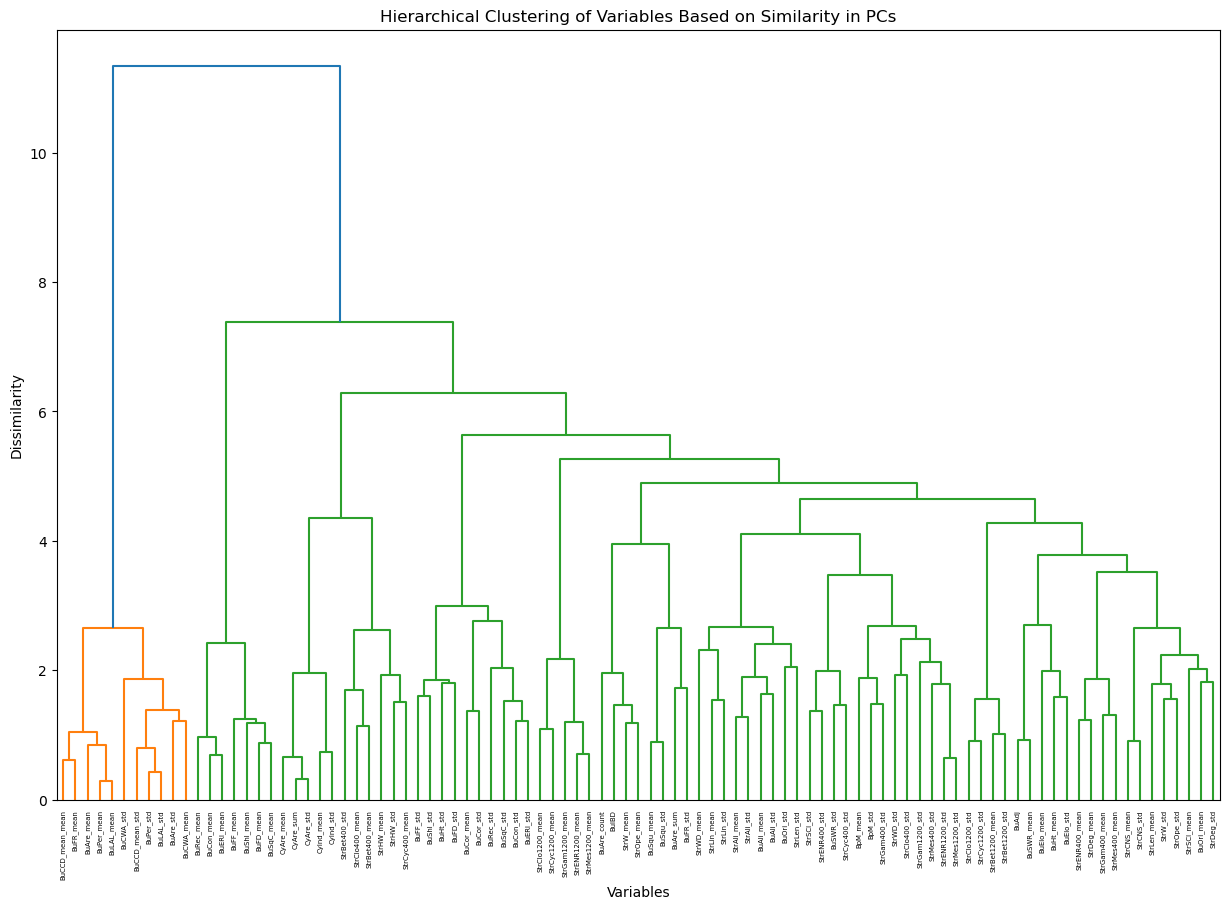

In [48]:
Z = linkage(1 - abs(correlation_matrix), method='ward')
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=correlation_matrix.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering of Variables Based on Similarity in PCs")
plt.xlabel("Variables")
plt.ylabel("Dissimilarity")
plt.show()

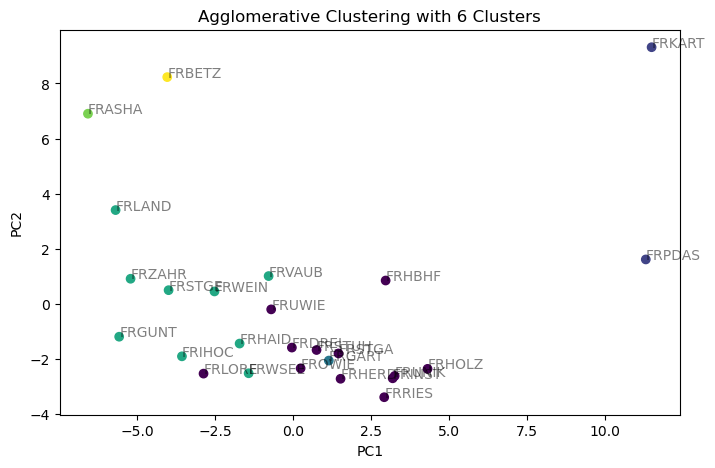

In [49]:
# find clusters in PCs

# Perform Agglomerative Clustering
n_clusters = 6
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(transformed_data)

# Get the cluster labels
cluster_labels = clustering.labels_

# Plot the clusters
plt.figure(figsize=(8, 5))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=cluster_labels, cmap='viridis')
for i, station_id in enumerate(station_ids):
    plt.annotate(station_id, (transformed_data[i, 0], transformed_data[i, 1]),alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Agglomerative Clustering with {n_clusters} Clusters')
plt.show()


R^2: 1.0
Intercept: 0.14414687884197727
Coefficients:
PC1: 0.1291439981542801
PC2: 0.020875634942773218
PC3: 0.00330647761266734
PC4: -0.030222256333948736
PC5: 0.0027423635799948202
PC6: -0.010242399601120087
PC7: -0.12077714220816656
PC8: 0.13163368224848618
PC9: -0.0010746988179832575
PC10: -0.21476376025626057
PC11: -0.1250285370607699
PC12: 0.17114426779156536
PC13: 0.040190572554085265
PC14: 0.10042817569778255
PC15: 0.08360364670224923
PC16: -0.0593365878229107
PC17: -0.07760898927558155
PC18: 0.12483116954503032
PC19: 0.10654467295661316
PC20: 0.2282986192537402
PC21: 0.3097997102082853
PC22: -0.45067558540039043
PC23: 0.004860119113249087
PC24: -0.09003783604350009
PC25: 0.21778236599340442
PC26: 0.0378934120115257


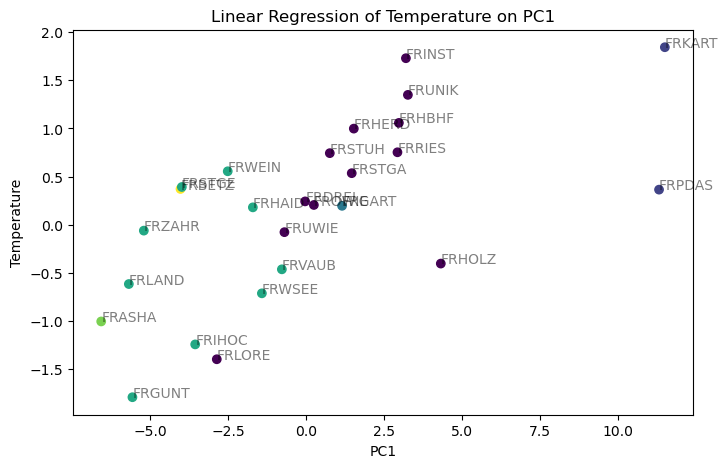

In [50]:
# do linear regression on the PCs and temp and print r squared for each PC

# Fit a linear regression model
model = LinearRegression()
model.fit(transformed_data, temp_result)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Get the R^2 value
r_squared = model.score(transformed_data, temp_result)

print(f'R^2: {r_squared}')


# Print the coefficients
print(f'Intercept: {intercept}')
print('Coefficients:')
for i, coef in enumerate(coefficients):
    print(f'PC{i+1}: {coef}')

    
    
# Plot the regression line
plt.figure(figsize=(8, 5))
plt.scatter(transformed_data[:, 0], temp_result, c=cluster_labels, cmap='viridis', linestyle='None')
plt.plot(transformed_data[:, 0], model.predict(transformed_data), color='red', linestyle='None')
for i, station_id in enumerate(station_ids):
    plt.annotate(station_id, (transformed_data[i, 0], temp_result.iloc[i]), alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('Temperature')
plt.title('Linear Regression of Temperature on PC1')
plt.show()

In [51]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import r2_score

In [52]:
# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split(transformed_data, temp_result, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train) 
  
# making predictions 
predictions = model.predict(X_test) 
  
# model evaluation 
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 
print('r2_score : ', r2_score(y_test, predictions))

mean_squared_error :  1.067069587494459
mean_absolute_error :  0.8191652410868054
r2_score :  -0.7127079608274567


Intercept: 0.1441468788419773
Coefficient: 0.1291439981542801
R^2: 0.4133859080536668


<Figure size 800x500 with 0 Axes>

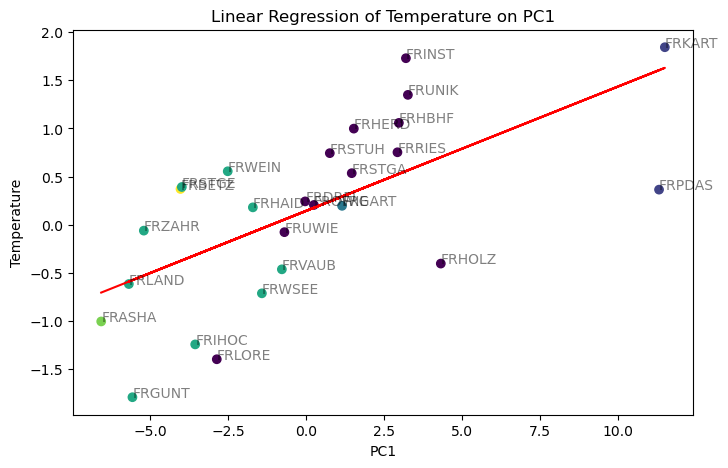

Intercept: 0.1441468788419773
Coefficient: 0.02087563494277319
R^2: 0.0061255406140928725


<Figure size 800x500 with 0 Axes>

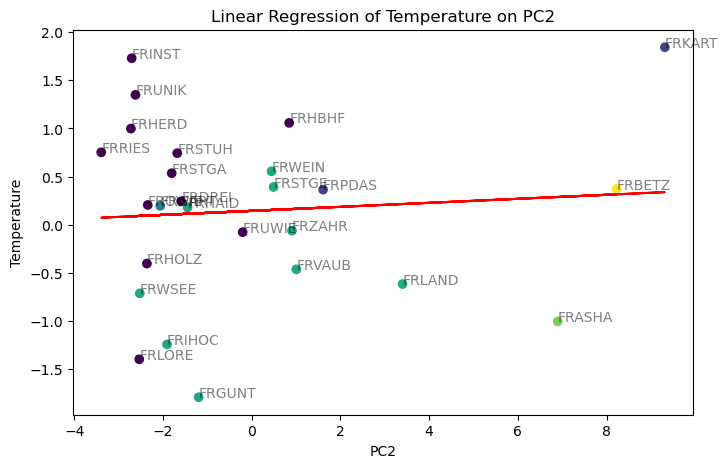

Intercept: 0.1441468788419773
Coefficient: 0.0033064776126675226
R^2: 0.00010170613475102286


<Figure size 800x500 with 0 Axes>

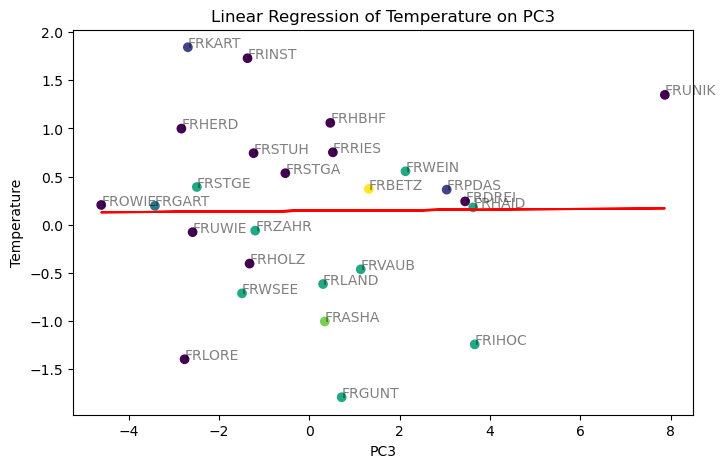

Intercept: 0.1441468788419773
Coefficient: -0.03022225633394847
R^2: 0.0074358343061610155


<Figure size 800x500 with 0 Axes>

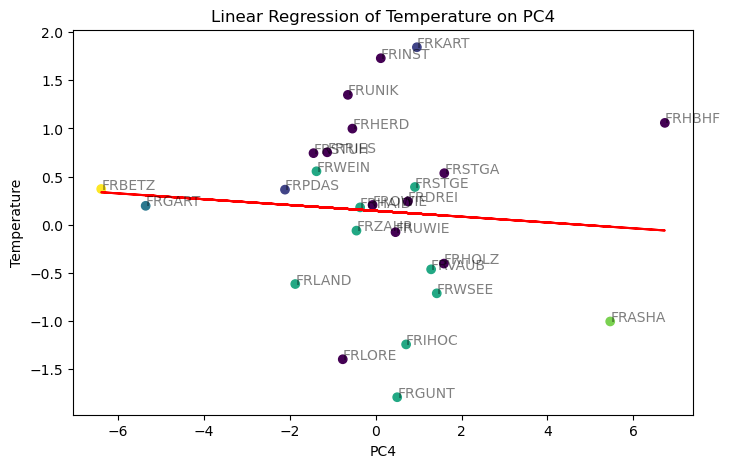

Intercept: 0.1441468788419773
Coefficient: 0.0027423635799946867
R^2: 4.6679323684295504e-05


<Figure size 800x500 with 0 Axes>

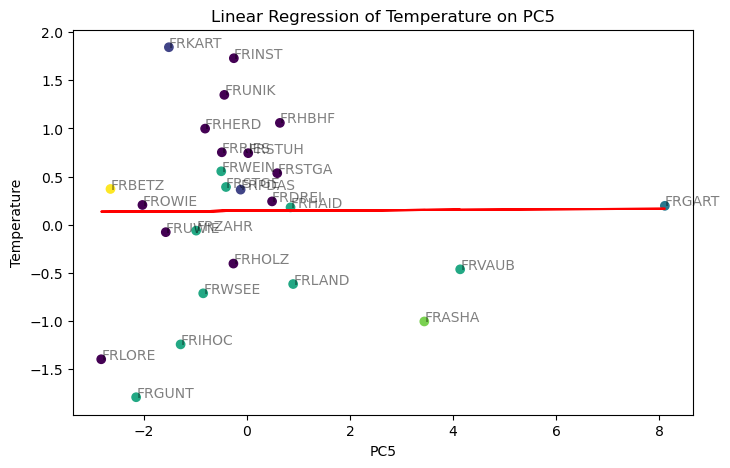

Intercept: 0.1441468788419773
Coefficient: -0.010242399601120592
R^2: 0.0005469593495028846


<Figure size 800x500 with 0 Axes>

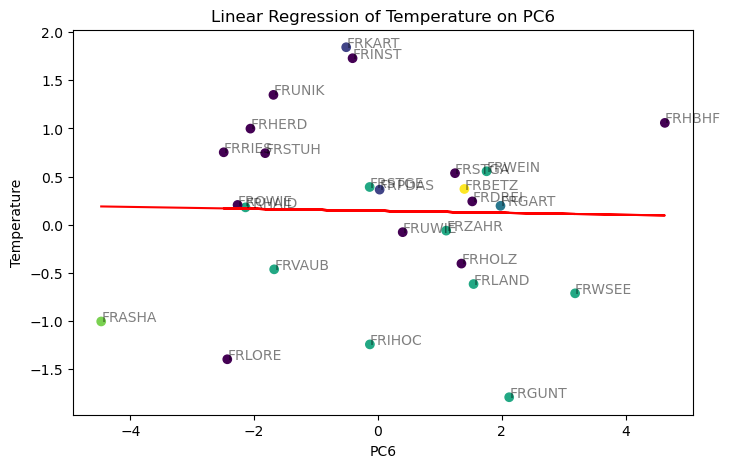

Intercept: 0.14414687884197733
Coefficient: -0.12077714220816631
R^2: 0.05918014561734075


<Figure size 800x500 with 0 Axes>

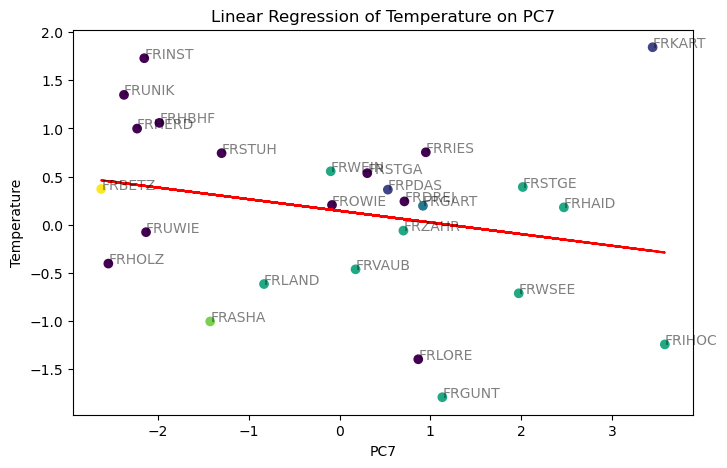

Intercept: 0.1441468788419773
Coefficient: 0.13163368224848623
R^2: 0.06320156351866013


<Figure size 800x500 with 0 Axes>

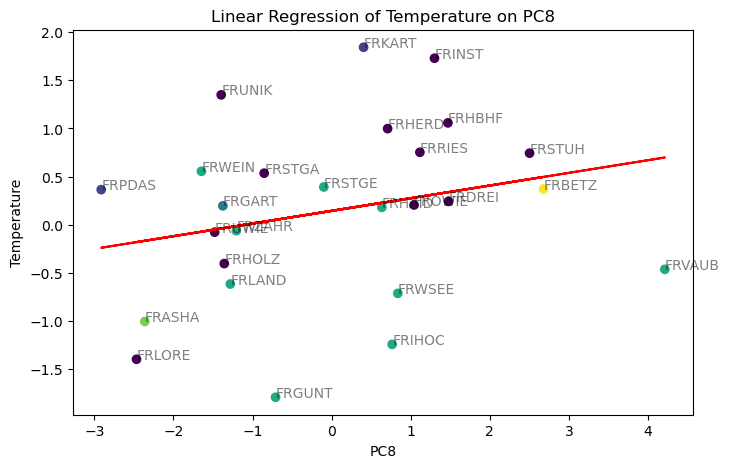

Intercept: 0.1441468788419773
Coefficient: -0.0010746988179832564
R^2: 3.939247198658791e-06


<Figure size 800x500 with 0 Axes>

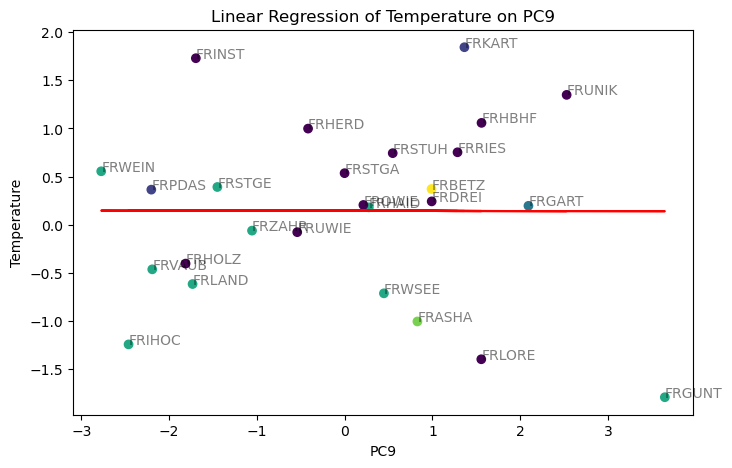

Intercept: 0.1441468788419773
Coefficient: -0.21476376025626068
R^2: 0.1358248755871424


<Figure size 800x500 with 0 Axes>

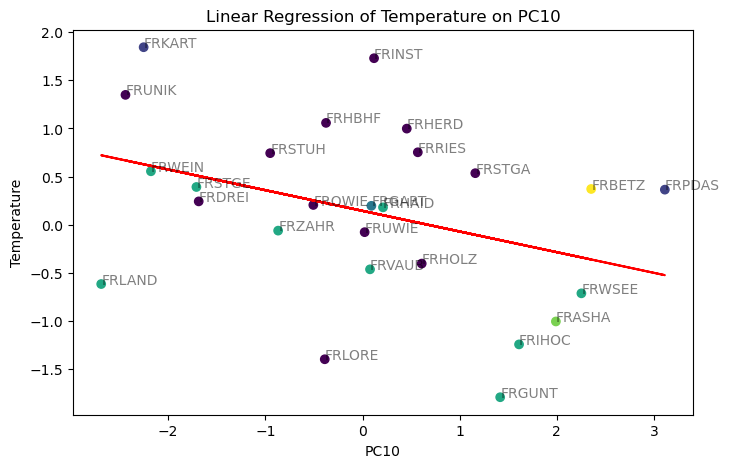

Intercept: 0.1441468788419773
Coefficient: -0.1250285370607701
R^2: 0.037793475366964424


<Figure size 800x500 with 0 Axes>

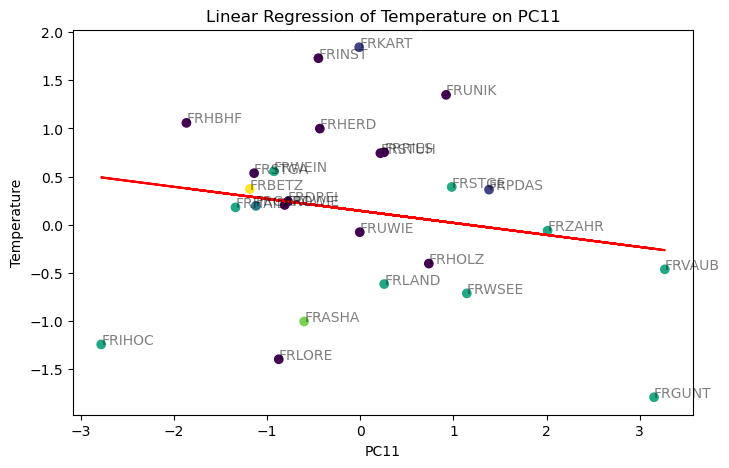

Intercept: 0.14414687884197727
Coefficient: 0.17114426779156564
R^2: 0.05772229925055783


<Figure size 800x500 with 0 Axes>

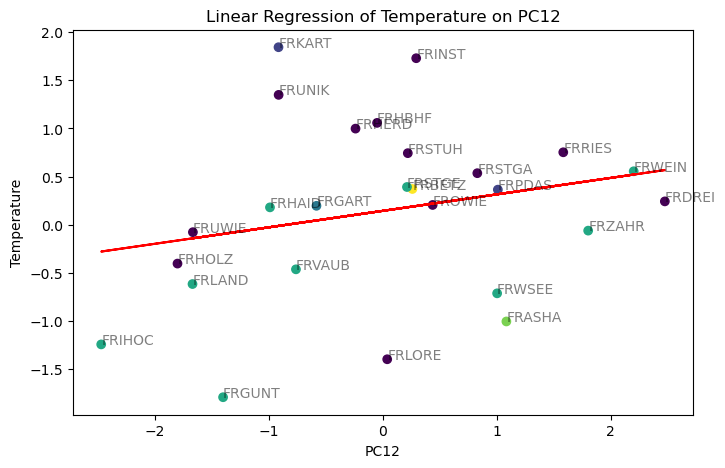

Intercept: 0.1441468788419773
Coefficient: 0.04019057255408491
R^2: 0.002836430808652479


<Figure size 800x500 with 0 Axes>

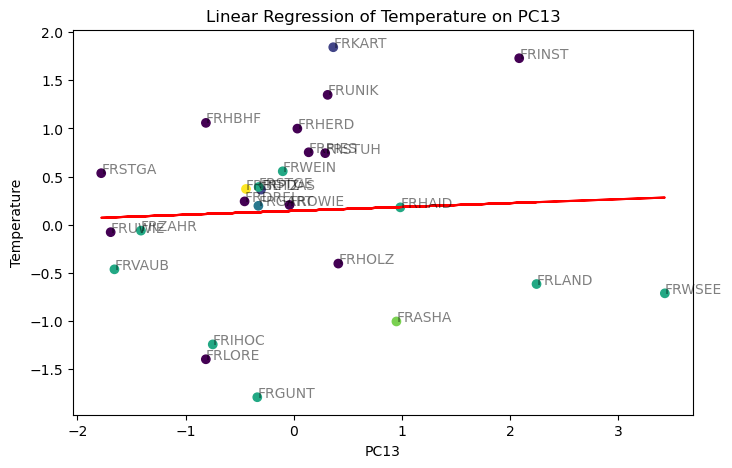

Intercept: 0.14414687884197733
Coefficient: 0.1004281756977838
R^2: 0.01381594870123426


<Figure size 800x500 with 0 Axes>

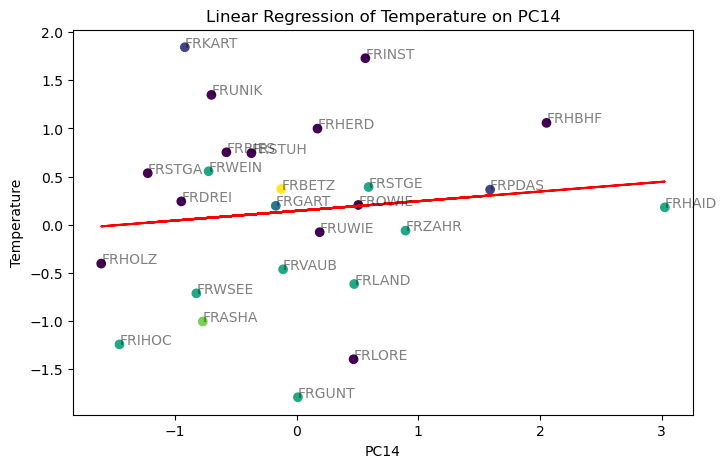

Intercept: 0.1441468788419773
Coefficient: 0.08360364670224986
R^2: 0.00810188992252825


<Figure size 800x500 with 0 Axes>

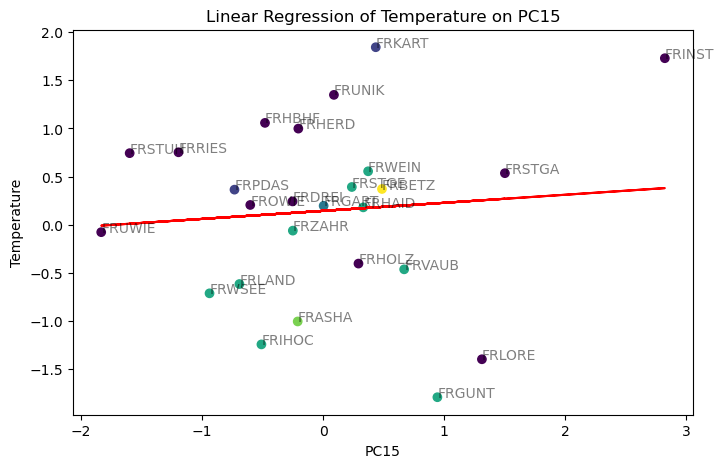

Intercept: 0.1441468788419773
Coefficient: -0.059336587822910354
R^2: 0.0033297893081750685


<Figure size 800x500 with 0 Axes>

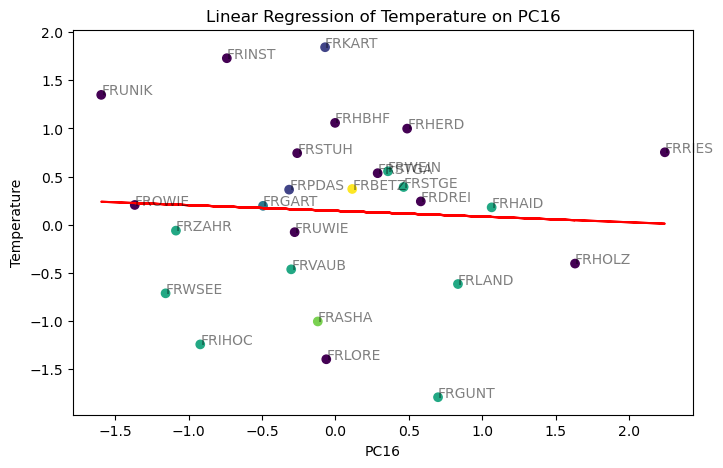

Intercept: 0.1441468788419773
Coefficient: -0.0776089892755821
R^2: 0.00491418816724476


<Figure size 800x500 with 0 Axes>

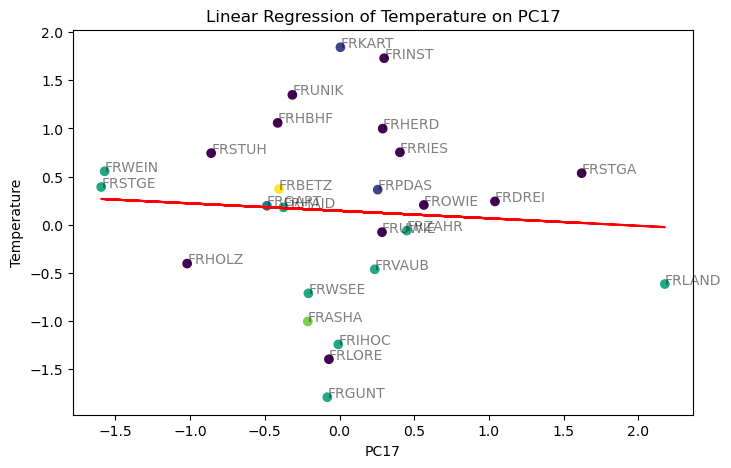

Intercept: 0.1441468788419773
Coefficient: 0.12483116954502982
R^2: 0.010134197113273014


<Figure size 800x500 with 0 Axes>

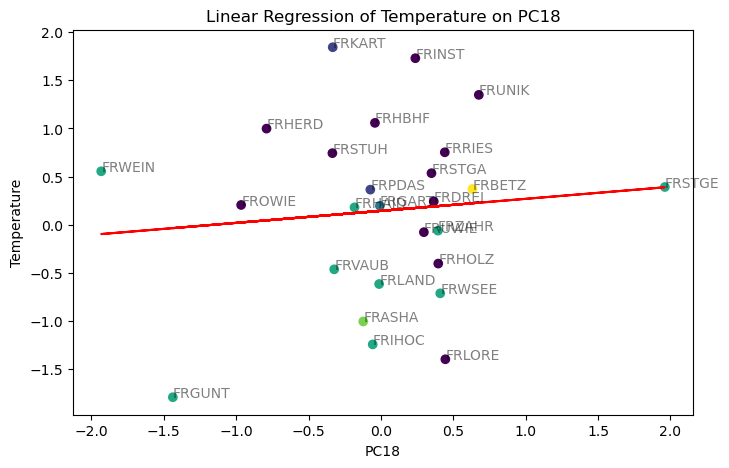

Intercept: 0.1441468788419773
Coefficient: 0.10654467295661371
R^2: 0.006815990480254941


<Figure size 800x500 with 0 Axes>

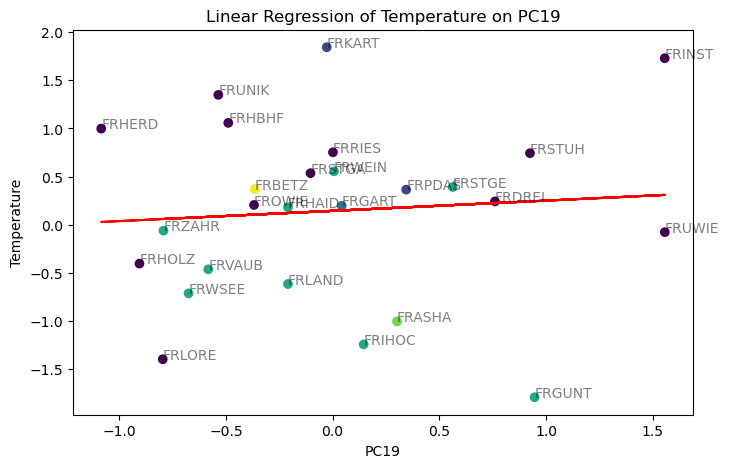

Intercept: 0.1441468788419773
Coefficient: 0.22829861925374045
R^2: 0.027897371775525315


<Figure size 800x500 with 0 Axes>

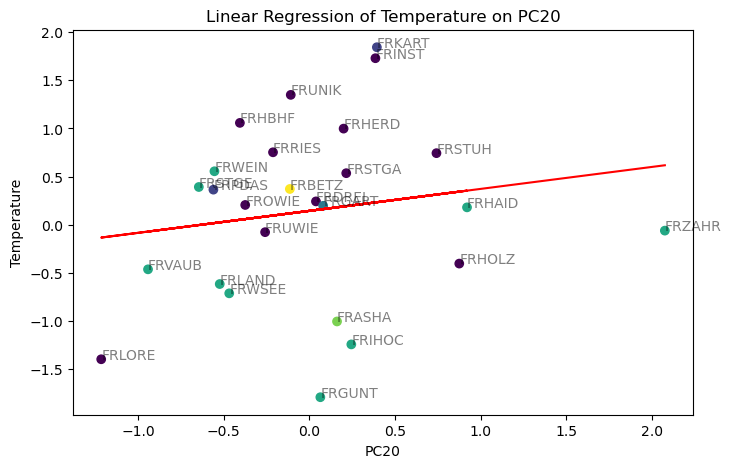

Intercept: 0.1441468788419773
Coefficient: 0.30979971020828484
R^2: 0.044466291460692586


<Figure size 800x500 with 0 Axes>

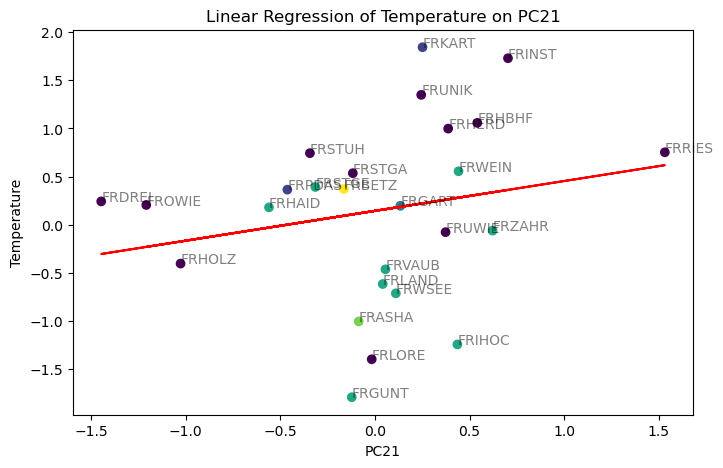

Intercept: 0.14414687884197727
Coefficient: -0.4506755854003903
R^2: 0.086190642100053


<Figure size 800x500 with 0 Axes>

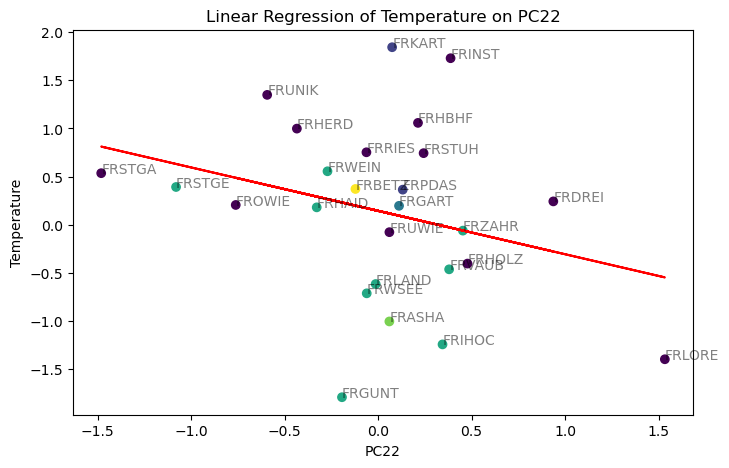

Intercept: 0.1441468788419773
Coefficient: 0.004860119113249895
R^2: 6.342598934616639e-06


<Figure size 800x500 with 0 Axes>

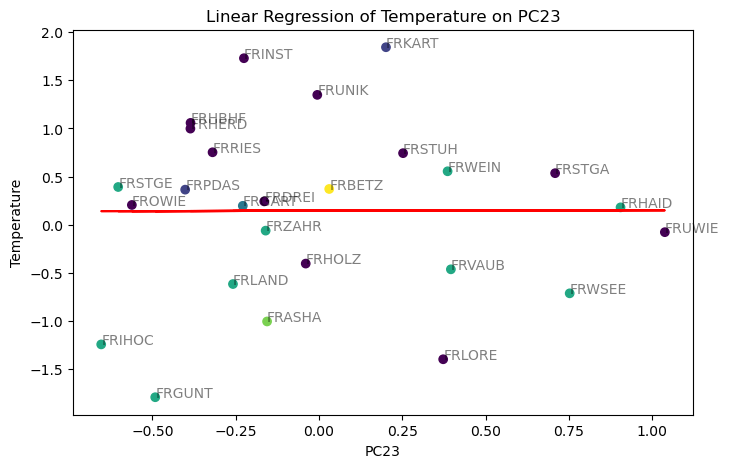

Intercept: 0.1441468788419773
Coefficient: -0.09003783604349921
R^2: 0.0017443531164337278


<Figure size 800x500 with 0 Axes>

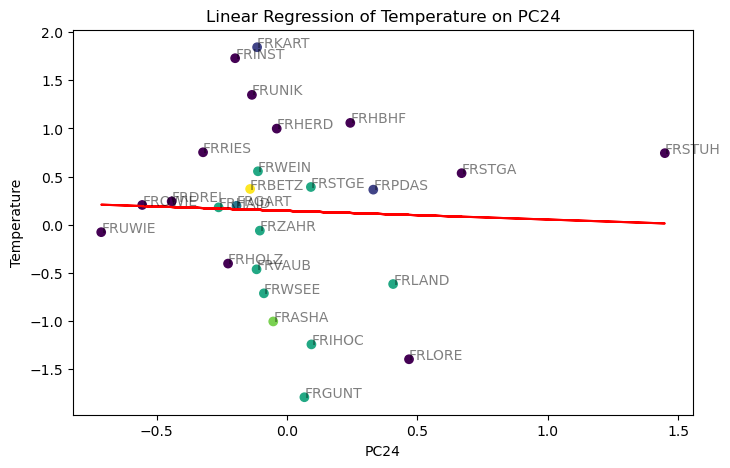

Intercept: 0.1441468788419773
Coefficient: 0.21778236599340195
R^2: 0.008377638077270433


<Figure size 800x500 with 0 Axes>

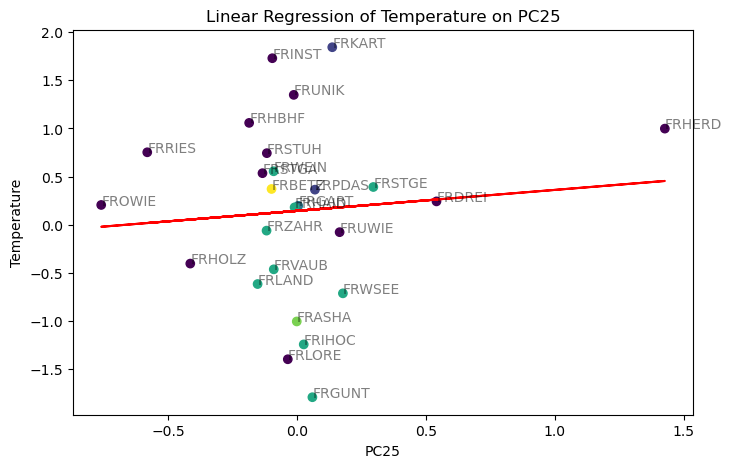

Intercept: 0.1491039006673669
Coefficient: -108088546013492.25
R^2: 0.001774143946304374


<Figure size 800x500 with 0 Axes>

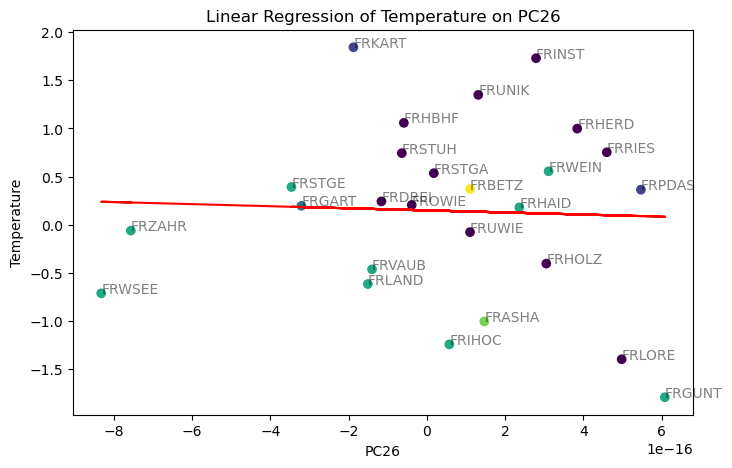

In [53]:
# regression between temperature and PC1

for i in range(0, 26):
    plt.figure(figsize=(8, 5))
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(transformed_data[:, i].reshape(-1, 1), temp_result)

    # Get the coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    # Get the R^2 value
    r_squared = model.score(transformed_data[:, i].reshape(-1, 1), temp_result)

    # Print the coefficients
    print(f'Intercept: {intercept}')
    print(f'Coefficient: {coefficients[0]}')
    print(f'R^2: {r_squared}')

    # Plot the regression line

    plt.figure(figsize=(8, 5))
    plt.scatter(transformed_data[:, i], temp_result, c=cluster_labels, cmap='viridis')
    plt.plot(transformed_data[:, i], model.predict(transformed_data[:, i].reshape(-1, 1)), color='red')
    for j, station_id in enumerate(station_ids):
        plt.annotate(station_id, (transformed_data[j, i], temp_result.iloc[j]), alpha=0.5)
    plt.xlabel('PC'+str(i+1))
    plt.ylabel('Temperature')
    plt.title('Linear Regression of Temperature on PC'+str(i+1))
    plt.show()


In [88]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

######################################## Data preparation #########################################

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split(transformed_data, temp_result, test_size=0.3, random_state=101) 
  
################################################ Train #############################################

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

# Built-in feature importance (Gini Importance)
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({'PC': range(1,27), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

y_pred = rf.predict(X_test)
print('r2_score : ', r2_score(y_test, predictions))

    PC  Gini Importance
0    1         0.217190
7    8         0.132119
11  12         0.092194
18  19         0.063760
17  18         0.044932
24  25         0.044624
1    2         0.038405
8    9         0.037660
21  22         0.037350
9   10         0.034183
14  15         0.033340
5    6         0.028553
20  21         0.025759
4    5         0.025210
23  24         0.023561
19  20         0.018250
3    4         0.018026
13  14         0.016126
6    7         0.014848
22  23         0.012987
15  16         0.011786
2    3         0.010315
10  11         0.008967
12  13         0.006379
16  17         0.003475
25  26         0.000000
r2_score :  -0.058082461155522624


In [138]:
#r squared of linear regression using just PC1 and PC7 with test and train data
X_train, X_test, y_train, y_test = train_test_split(transformed_data[:, [0,6]], temp_result, test_size=0.2, random_state=26)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('r2_score : ', r2_score(y_test, predictions))


r2_score :  -0.6545332704425972


In [99]:
# for r squared, split into test and training

R^2: 0.559788042465736


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_17994/514316653.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(transformed_data[:, 0], transformed_data[:, 6], temp_result, c='black', cmap='viridis')


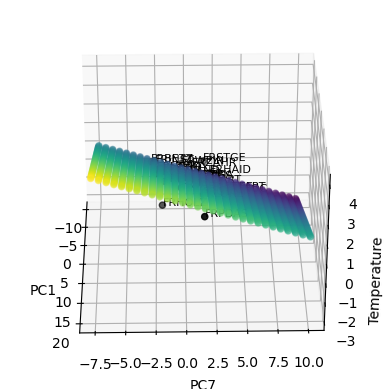

In [103]:
# linear regression of PC1 and PC4 and temp
station_ids = params_scaled.dropna().index
unique_station_ids = station_ids.unique()

# for visualisation
x_pred = np.linspace(-10, 20, 30)   # range of porosity values
y_pred = np.linspace(-7.5, 10, 30)  # range of brittleness values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# Fit a linear regression model
model = LinearRegression()
model.fit(transformed_data[:, [0,6]], temp_result)
predicted = model.predict(model_viz)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Get the R^2 value
r_squared = model.score(transformed_data[:, [0,6]], temp_result)

print(f'R^2: {r_squared}')

# plot on 3d scatter plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed_data[:, 0], transformed_data[:, 6], temp_result, c='black', cmap='viridis')
ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, c=predicted,alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC7')
# Add text labels for station_id
for station_id in unique_station_ids:
    idx = station_ids == station_id
    for i in range(len(transformed_data[idx])):
        ax.text(transformed_data[idx][i, 0], transformed_data[idx][i, 6], temp_result[idx].iloc[i], 
                station_id, size=8, zorder=1, color='k')
ax.set_zlabel('Temperature')

for ii in np.arange(0, 360, 1):
    ax.view_init(elev=32, azim=ii)
    fig.savefig('gif_image%d.png' % ii)


plt.show()